In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

ModuleNotFoundError: No module named 'tensorboardX'

In [2]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 10
num_classes = 10
batch_size = 16
learning_rate = 0.001

# Tensorboard Summary Writer
writer = SummaryWriter()

In [3]:
# CIFAR10 dataset
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(), 
                                       normalize
                                      ])

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      normalize
                                     ])

train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                                  train=True, 
                                                  transform=train_transforms,
                                                  download=True)

test_dataset = torchvision.datasets.CIFAR10(root='data/',
                                                  train=False, 
                                                  transform=test_transforms)

# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)

def imshow(inp, title=None):
    """Imshow for Tensor."""
    # C, H, W -> H, W, C
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # to show unnormalized image
    inp = std * inp + mean
    
    return inp

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


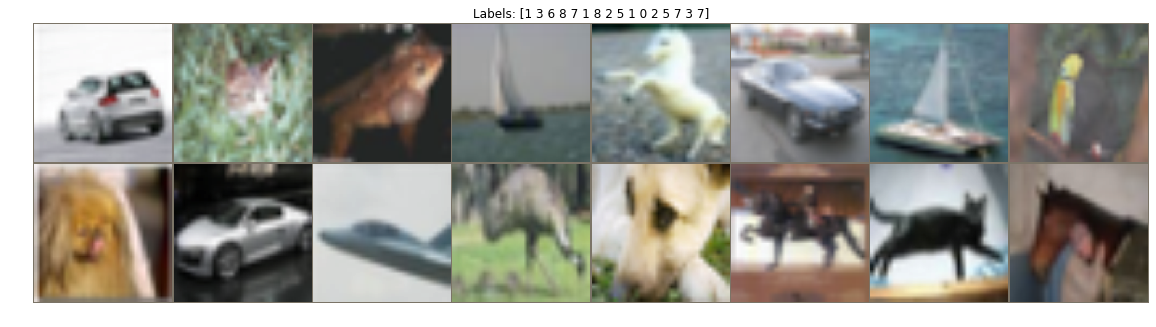

In [4]:
sample_img, sample_label = next(iter(test_loader))

out = torchvision.utils.make_grid(sample_img)
plt.figure(figsize=(20,10));
plt.title(f"Labels: {sample_label.numpy()}")
plt.axis('off');
plt.imshow(imshow(out));

In [5]:
# Load Pretrained Network and Freeze Layers except final classifer layers
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
squeezenet = torchvision.models.squeezenet1_1(pretrained=True)
set_parameter_requires_grad(squeezenet, True)

# Replace 1000 classes from imagenet pretraining to 10 for CIFAR 10
squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
squeezenet.num_classes = 10
squeezenet = squeezenet.to(device)

/home/pablo/anaconda3/envs/presentation/lib/python3.6/site-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/home/pablo/anaconda3/envs/presentation/lib/python3.6/site-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


In [6]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(squeezenet.parameters(), lr=learning_rate)

In [7]:
def train(data_loader, model, criterion, optimizer, epoch, train_step, device):
    model.train()
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward Pass
        output = model(images)
        loss = criterion(output, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}")
            writer.add_scalar('Train/Training Loss', loss.item(), train_step)
        train_step +=1
        
    return train_step

def test(data_loader, model, criterion, test_step, device):
    squeezenet.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = squeezenet(images)
            
            # Accuracy Measurement
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            acc =  (predicted == labels).sum().item() / labels.size(0)
            test_step +=1
                
        total_acc = correct /total
        print(f'Test Accuracy of the model on the test images: {total_acc}')
        writer.add_scalar('Test/Accuracy', total_acc, test_step)
        
        return test_step

In [8]:
# Train and Test SqueezeNet
train_step = 0
test_step = 0
for epoch in range(num_epochs):
    # tensorboard stuff
    writer.add_custom_scalars_multilinechart(['Train', 'Test'])
    
    train_step = train(train_loader, squeezenet, criterion, optimizer, epoch, train_step, device)
    test_step = test(test_loader, squeezenet, criterion, test_step, device)

Epoch [1/10], Step [100/3125], Loss: 0.8937
Epoch [1/10], Step [200/3125], Loss: 0.7977
Epoch [1/10], Step [300/3125], Loss: 0.7137
Epoch [1/10], Step [400/3125], Loss: 1.0520
Epoch [1/10], Step [500/3125], Loss: 0.5251
Epoch [1/10], Step [600/3125], Loss: 0.6805
Epoch [1/10], Step [700/3125], Loss: 0.5050
Epoch [1/10], Step [800/3125], Loss: 0.4399
Epoch [1/10], Step [900/3125], Loss: 0.6448
Epoch [1/10], Step [1000/3125], Loss: 0.2906
Epoch [1/10], Step [1100/3125], Loss: 0.8577
Epoch [1/10], Step [1200/3125], Loss: 0.1358
Epoch [1/10], Step [1300/3125], Loss: 0.7058
Epoch [1/10], Step [1400/3125], Loss: 1.1768
Epoch [1/10], Step [1500/3125], Loss: 0.3511
Epoch [1/10], Step [1600/3125], Loss: 0.4486
Epoch [1/10], Step [1700/3125], Loss: 0.3282
Epoch [1/10], Step [1800/3125], Loss: 0.6835
Epoch [1/10], Step [1900/3125], Loss: 0.6142
Epoch [1/10], Step [2000/3125], Loss: 0.1353
Epoch [1/10], Step [2100/3125], Loss: 0.7170
Epoch [1/10], Step [2200/3125], Loss: 0.9793
Epoch [1/10], Step 

In [9]:
# Save the model checkpoint
torch.save(squeezenet.state_dict(), 'squeezenet_cifar10.ckpt')